In [ ]:
pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
download_url = "https://www.kaggle.com/datasets/usdot/flight-delays"
od.download(download_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yaaashd
Your Kaggle Key: ··········


100%|██████████| 191M/191M [00:01<00:00, 136MB/s]


In [ ]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
data_filename = "./flight-delays/"


In [ ]:
df = pd.read_csv('./flight-delays/flights.csv', low_memory=False)

In [ ]:
df.shape

(5819079, 31)

In [ ]:
df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,2355.0,-4.0,22.0,17.0,320.0,298.0,272.0,2611,749.0,4.0,819,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,2355.0,-4.0,17.0,12.0,227.0,215.0,195.0,1617,427.0,3.0,446,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,2350.0,-9.0,17.0,7.0,221.0,222.0,197.0,1598,424.0,8.0,440,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,2353.0,-6.0,10.0,3.0,161.0,157.0,144.0,1189,327.0,3.0,340,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [ ]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [ ]:
#changing to 24 hour format
def format_hour(chain):
    if pd.isnull(chain):
        return np.nan
    else:
        if chain == 2400: chain = 0
        chain = "{0:04d}".format(int(chain))
        hour = datetime.time(int(chain[0:2]), int(chain[2:4]))
        return hour


In [ ]:
#combining date and time so that we get a tabular data in single column
def combine_date_hour(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [ ]:
#creating a new list in which each flight is appended with data cleaning we did
def create_flight_time(df, col):
    list = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols[1]):
            list.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            list.append(combine_date_hour(cols))
        else:
            cols[1] = format_hour(cols[1])
            list.append(combine_date_hour(cols))
    return pd.Series(list)


In [ ]:
#removing variable which are of no use
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR',
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                      'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                      'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                      'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,5,2354.0,-11.0,430,408.0,-22.0,205.0,194.0
1,AA,LAX,PBI,10,2.0,-8.0,750,741.0,-9.0,280.0,279.0
2,US,SFO,CLT,20,18.0,-2.0,806,811.0,5.0,286.0,293.0
3,AA,LAX,MIA,20,15.0,-5.0,805,756.0,-9.0,285.0,281.0
4,AS,SEA,ANC,25,24.0,-1.0,320,259.0,-21.0,235.0,215.0


In [ ]:
missing_percent = df.isna().sum().sort_values(ascending=False)*100/len(df)
missing_percent

ARRIVAL_DELAY          1.805629
ELAPSED_TIME           1.805629
ARRIVAL_TIME           1.589822
DEPARTURE_TIME         1.480526
DEPARTURE_DELAY        1.480526
SCHEDULED_TIME         0.000103
AIRLINE                0.000000
ORIGIN_AIRPORT         0.000000
DESTINATION_AIRPORT    0.000000
SCHEDULED_DEPARTURE    0.000000
SCHEDULED_ARRIVAL      0.000000
dtype: float64

In [ ]:
airlines_names = pd.read_csv('./flight-delays/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [ ]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [ ]:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats


,min,max,count,mean
AIRLINE,,,,
VX,-24.0,644.0,61385.0,9.022595
HA,-27.0,1433.0,76119.0,0.485713
F9,-46.0,1112.0,90290.0,13.350858
NK,-37.0,836.0,115454.0,15.944766
AS,-82.0,963.0,171910.0,1.785801
US,-35.0,759.0,194825.0,6.141137
B6,-31.0,1006.0,262843.0,11.514353
MQ,-36.0,1544.0,280282.0,10.125188
UA,-40.0,1314.0,509534.0,14.435441


In [ ]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [ ]:
font = {'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches

In [ ]:
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

In [ ]:
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']

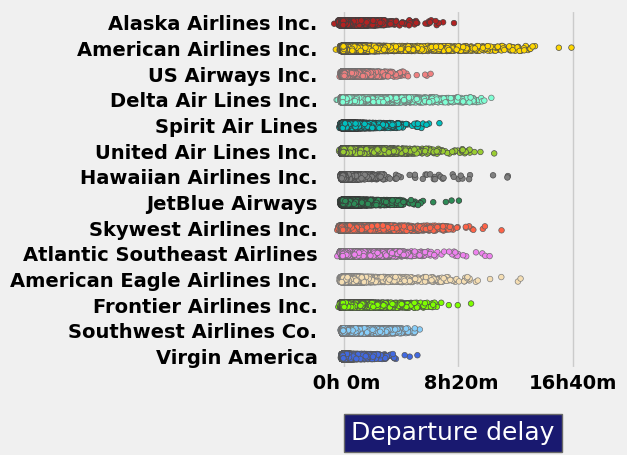

In [ ]:
#using data cleaning first we found the total delay of flights on basis on each airline and plotted all readings on graph -- global stats table
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)

In [ ]:
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)

Text(0.5, 0, 'No of Flights on Basis of Delay Level')

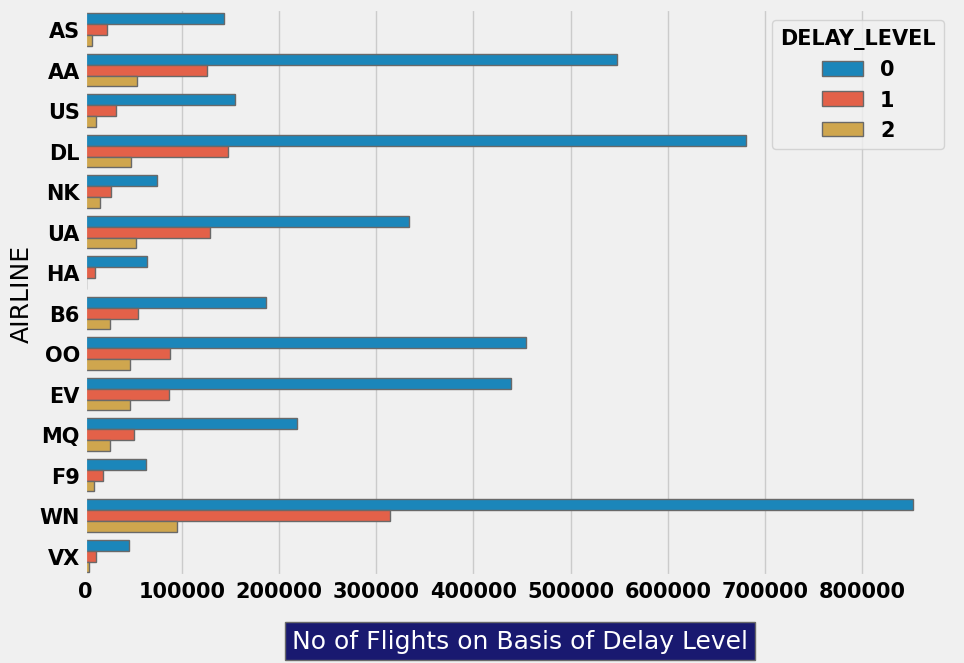

In [ ]:
#compared each airline on the basis of there flight delay level
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
plt.xlabel('No of Flights on Basis of Delay Level', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
#level 0 - on time
#level 1 - small delay time 5<t<45
#level 2 - big delay time t>45

In [ ]:
def func(x, a, b):
    return a * np.exp(-x/b)

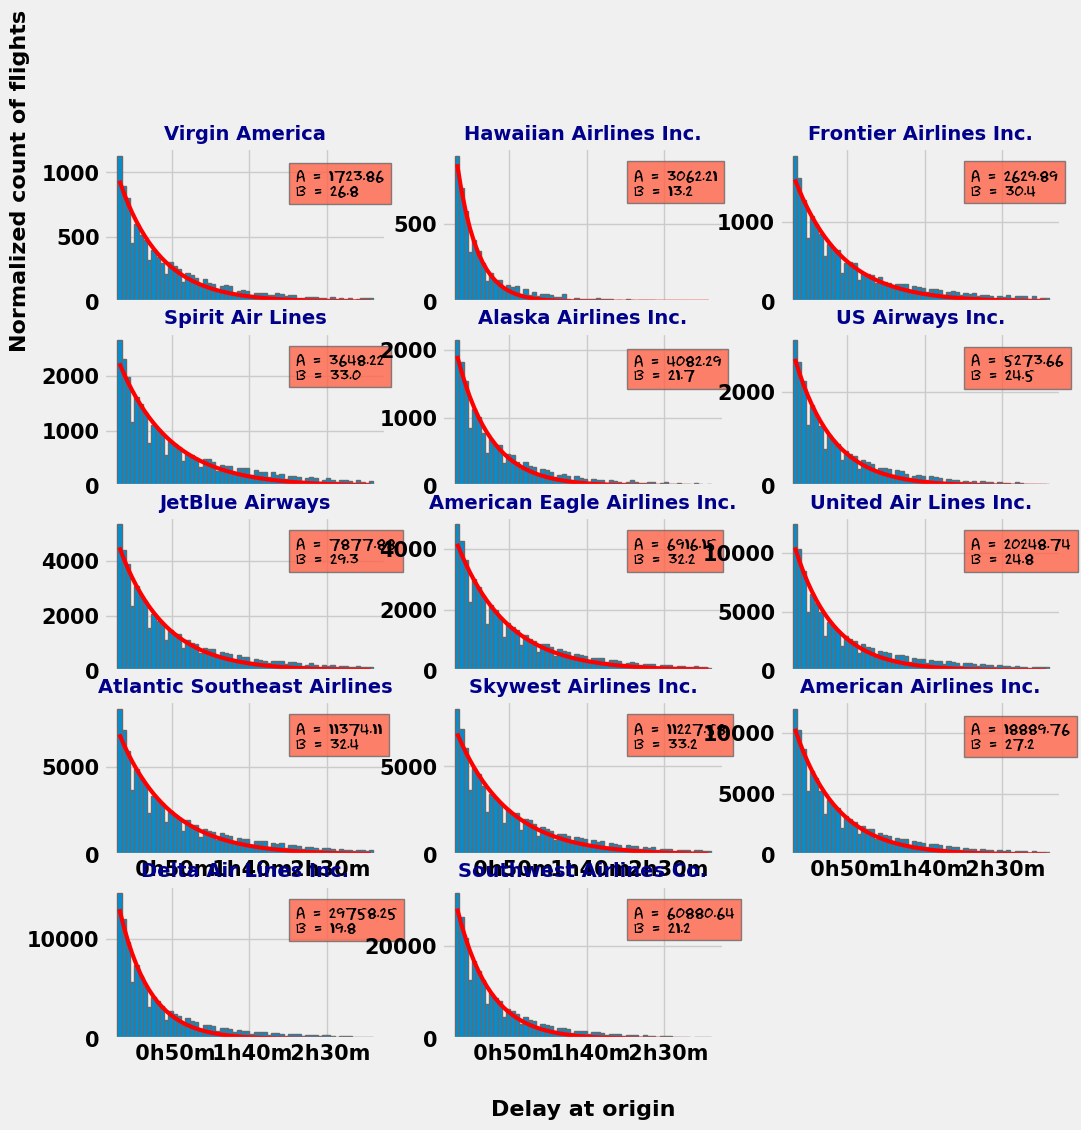

In [ ]:
#here we plot a histogram to get more detailed view of the delay in time and number of flights delayed on that particular time of each airline
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)

    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],range = (15,180),bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])

    points.append(popt)
    label_company.append(carrier_name)

    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)

    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])

    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')

    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)

    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})

plt.tight_layout()

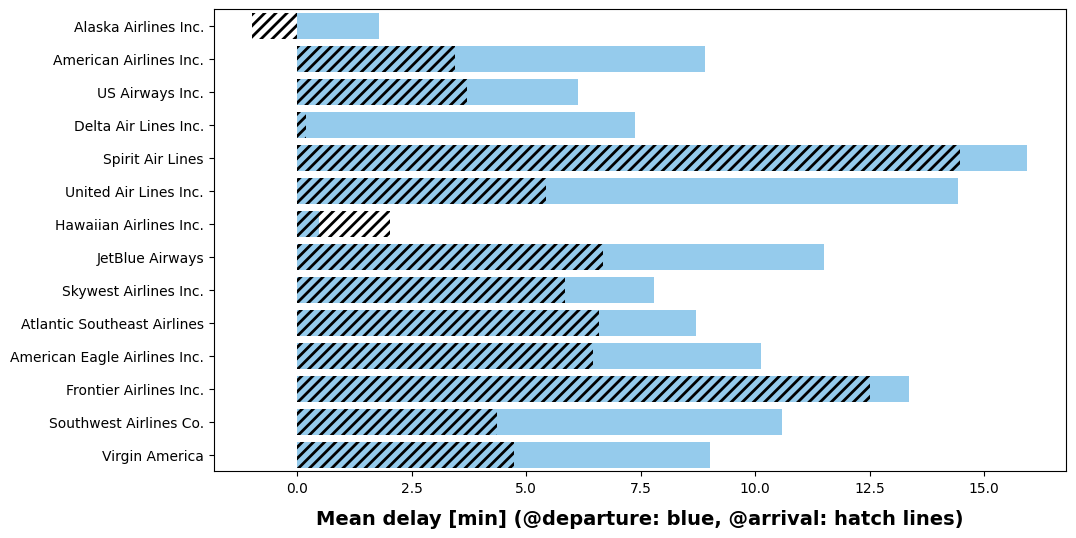

In [ ]:
#delay can also be on the basis of arrival
#so a bar plot is there showing what is the delay on departure and delay on arrival of each airline
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);
fig

In [ ]:
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 628


In [ ]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

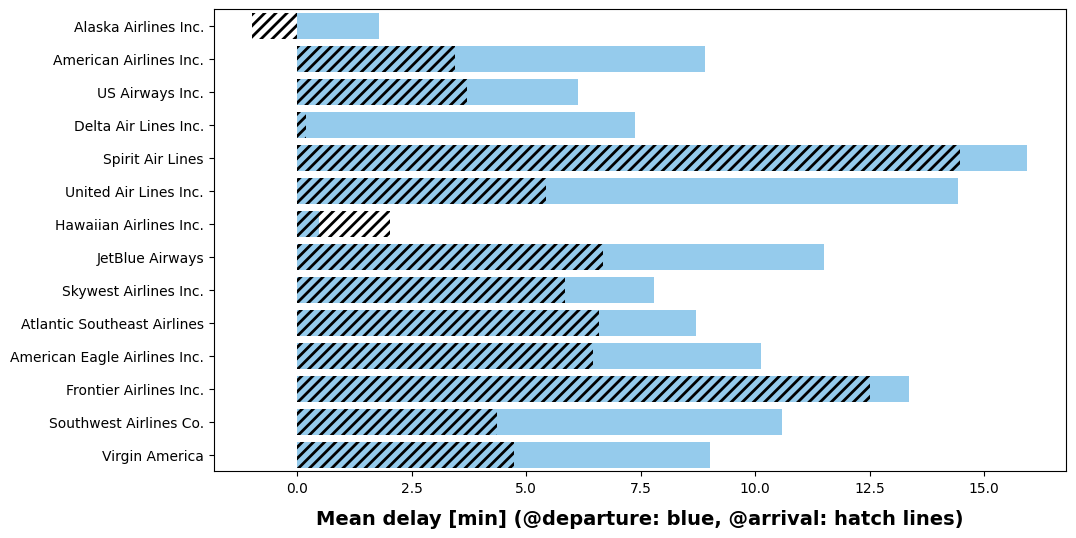

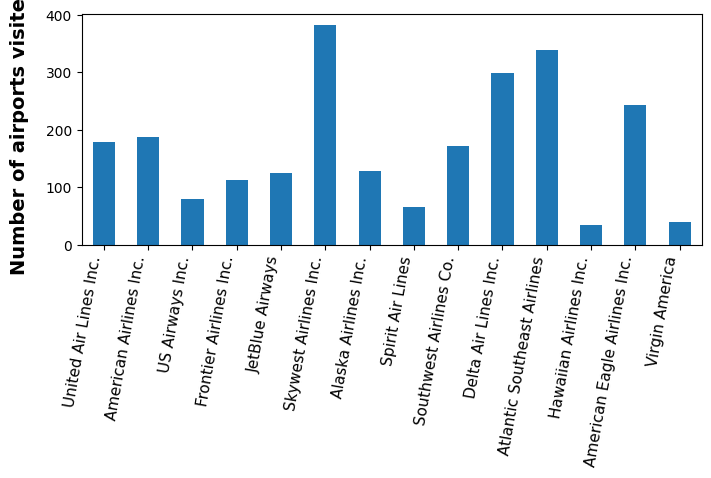

In [ ]:
#no of destinations served by the airline
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [ ]:
temp = pd.read_csv('./flight-delays/airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [ ]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

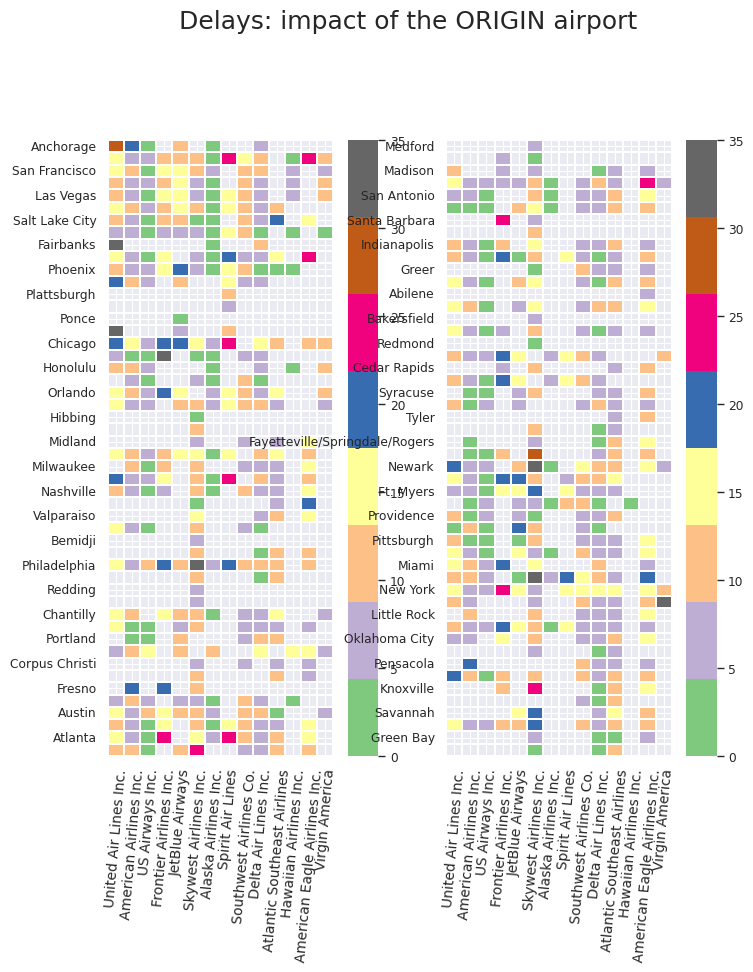

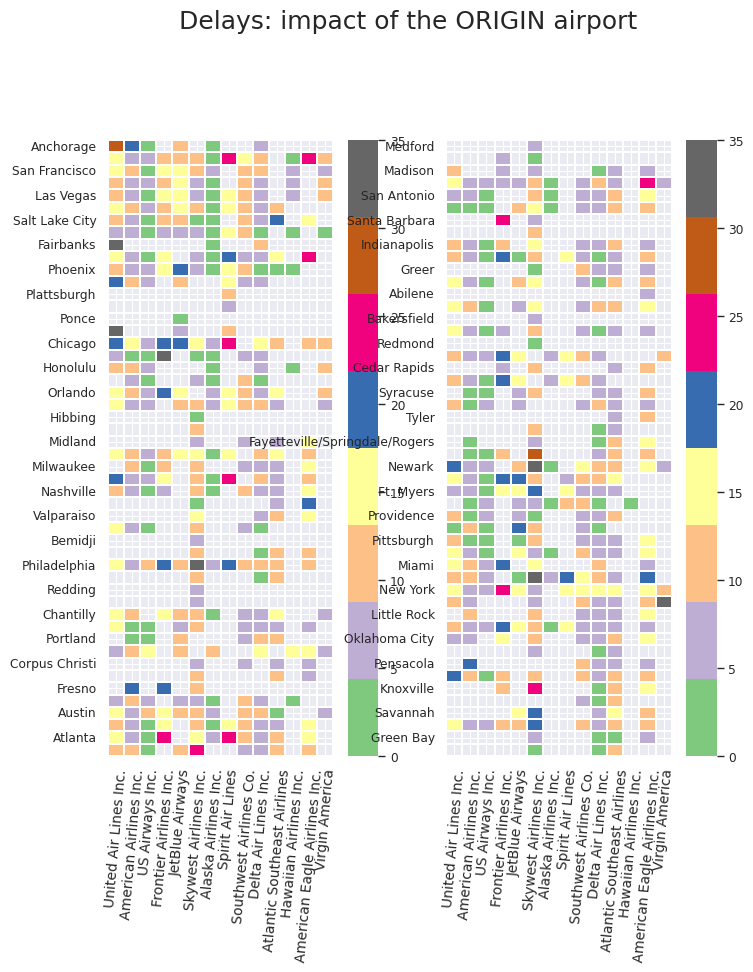

In [ ]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the ORIGIN airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.show()
fig

In [ ]:
airport_mean_delaysD = pd.DataFrame(pd.Series(df['DESTINATION_AIRPORT'].unique()))
airport_mean_delaysD.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df2 = df[df['AIRLINE'] == carrier]
    test = df2['DEPARTURE_DELAY'].groupby(df['DESTINATION_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delaysD[carrier] = test.loc[:, 'mean']

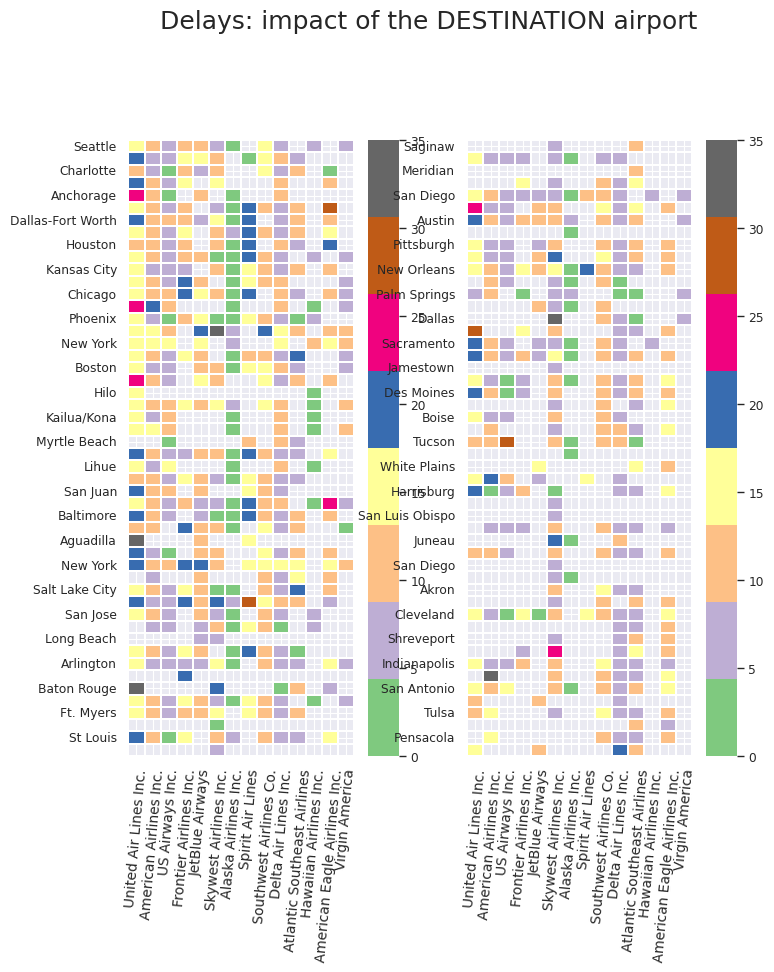

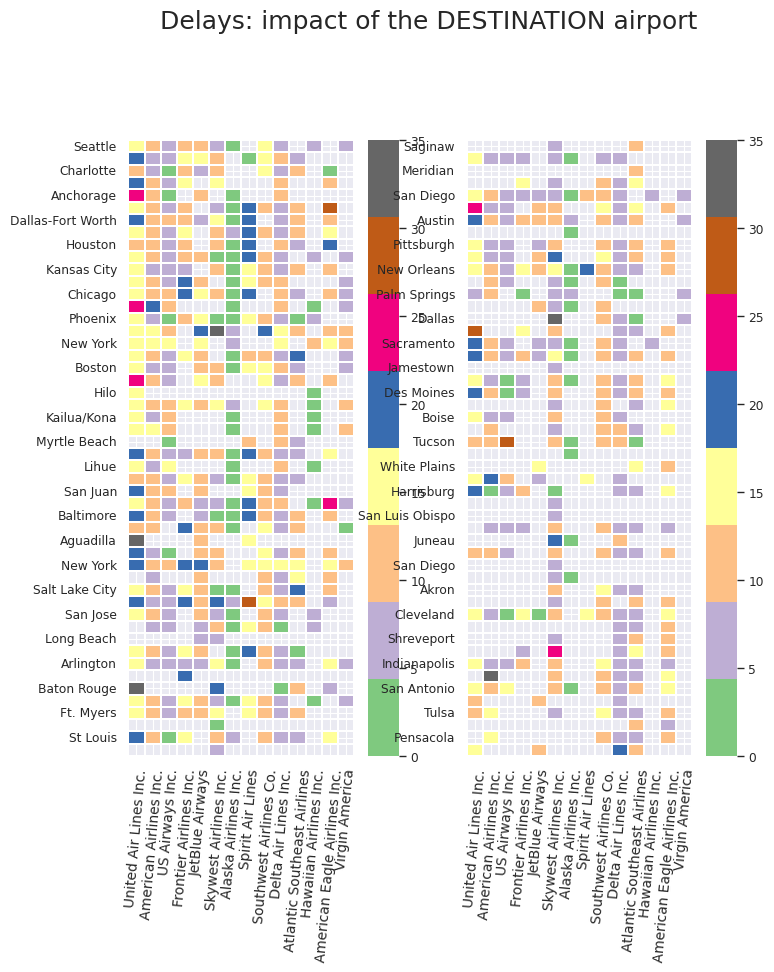

In [ ]:
sns.set(context="paper")
figD = plt.figure(1, figsize=(8,8))

ax = figD.add_subplot(1,2,1)
subset = airport_mean_delaysD.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = figD.add_subplot(1,2,2)
subset = airport_mean_delaysD.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
figD.text(0.5, 1.02, "Delays: impact of the DESTINATION airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.show()
figD

In [ ]:
class Figure_style():

    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))

        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))

    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy

    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)

    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')

    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()

    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)

    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)

    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)

    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)

    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])

    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])

In [ ]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
df2

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DELAY_LEVEL
5249846,WN,PHX,MDW,515,543.0,28.0,930,948.0,18.0,195.0,185.0,1
5683159,WN,PHX,MDW,515,534.0,19.0,930,935.0,5.0,195.0,181.0,1
5740874,WN,PHX,HOU,515,514.0,-1.0,840,914.0,34.0,145.0,180.0,0
1026800,WN,PHX,STL,525,531.0,6.0,1015,1028.0,13.0,170.0,177.0,1
1550219,WN,PHX,LAX,525,539.0,14.0,650,719.0,29.0,85.0,100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5322693,WN,PHX,LAX,2335,6.0,31.0,2355,23.0,28.0,80.0,77.0,1
5699338,WN,PHX,LAX,2335,2355.0,20.0,2355,23.0,28.0,80.0,88.0,1
5756986,WN,PHX,LAX,2335,111.0,96.0,2355,130.0,95.0,80.0,79.0,2
5266324,WN,PHX,SAN,2345,2347.0,2.0,2355,4.0,9.0,70.0,77.0,0


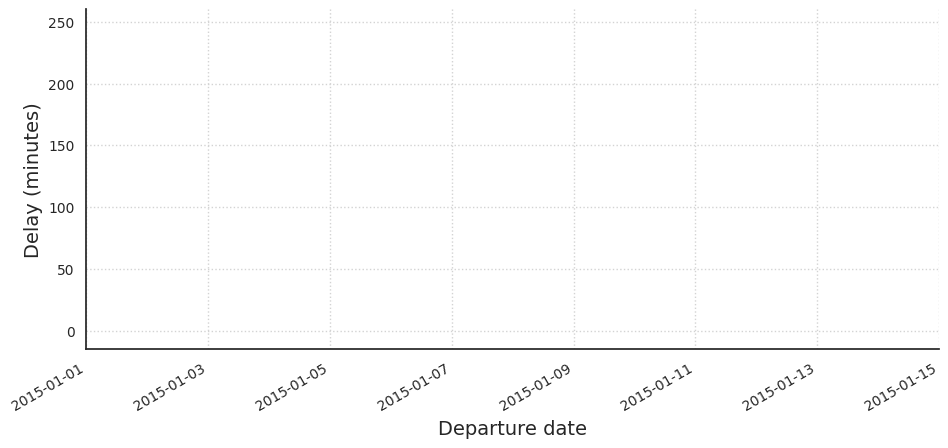

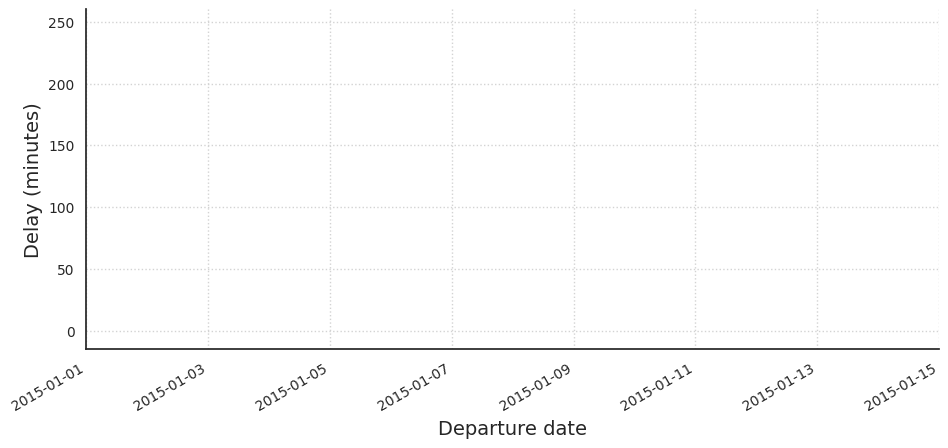

In [ ]:
fig1 = Figure_style(11,5,1,1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure date', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,15)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)
plt.show()